In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from scipy.stats import linregress
# Model 3: Miniaturized 'real' CRISPEY Experiment

#Yes, bottleneck_counts and extract_DNA are the same #readability
def bottleneck_counts(counts, bottleneck_size=800000):
    #samples strains based on a poisson with lambda = their fraction in the library * bottleneck_size
    #modeling the culture bottleneck
    lambdas = counts/counts.sum()*bottleneck_size
    lambdas_w_noise = lambdas + np.random.normal(0,0.05*lambdas.mean(), size = len(lambdas))
    lambdas_w_noise[lambdas_w_noise<0] = 0
    lambdas_w_noise[lambdas == 0] = 0
    return np.array([np.random.poisson(i) for i in np.round(lambdas_w_noise)])

def extract_DNA(counts, extraction_barcodes):
    
    '''
    samples strains based from a poisson with lambda = their fraction in the library * extraction_barcodes
    modeling the culture bottleneck
    
    Parameters
    ----------
    counts : Numpy array (int)
        Counts for strains at the end of a time point 
    extraction_barcodes : int
        number of total barcodes to be extracted (average coverage in extraction * )
   
    Returns
    -------
    Numpy array
       Array containing the final sequenced counts for each strain

    '''
    lambdas = counts/counts.sum()*extraction_barcodes
    lambdas_w_noise = lambdas + np.random.normal(0,0.05*lambdas.mean(), size = len(lambdas))
    lambdas_w_noise[lambdas_w_noise<0] = 0
    lambdas_w_noise[lambdas == 0] = 0
    return np.array([np.random.poisson(i) for i in np.round(lambdas_w_noise)])

def PCR(counts, pcr_cycles, efficiency):
    '''
    simulates PCR process with some error (no clue what would be reasonable there)
    
    Parameters
    ----------
    counts : Numpy array (int)
        Counts for strains after DNA extraction 
    num_reads : int
        Rough number of sequencing reads
    pcr_cycles: int
        Number of PCR cycles
    
    Returns
    -------
    Numpy array
       Array containing the PCR output

    '''
    pcr = np.copy(counts)
    for i in range(pcr_cycles):
        num_amplified = np.random.binomial(pcr,efficiency)
        pcr = (pcr-num_amplified)+num_amplified*2
    return pcr

def calculate_fitness(s, e, num_gens):
    #calculates fitness as a function of start and end counts
    #currently not used
    try:
        fitness = 2**(np.log2((e-s)/s +1)/num_gens)
        if fitness <.001:
            fitness = None
    except:
        fitness = None
    return fitness

def simulate_crispey(fitness_size, bottleneck, \
                     num_strains = 400, num_tp = 6, gens_per_tp = 5, \
                     extraction_coverage = 4, pcr_cycles = 24,
                    num_reps = 1, pcr_efficiency = .9):
    '''

    Assuming a lot of poisson processes, simulates a Crispey competition

    Parameters
    ----------
    fitness_size : float
        Scale for exponential distribution of relative fitness differences from 1 for strains in the competition. 
    bottleneck : int
        Rough number of yeast passaged into the next timepoint, also used to derive the initial counts for strains
    num_strains: int
        Number of unique strains with fitness values being measured
    num_tp: int
        Number of time points in the competition when yeast are passaged/sampled.
    gens_per_tp: int
        Number of doublings a neutral yeast strain would go through in each timepoint
    extraction_coverage: float
        Average coverage of each strain in the extracted DNA
    sequencing_reads: int
        Rough number of reads to be sequenced
    pcr_cycles: int
        Number of PCR cycles performed on extracted DNA
    num_reps: int
        Number of replicate competitions performed
    Returns
    -------
    output_df: Pandas DataFrame
        DataFrame containing the sequenced counts of each strain in each time point for each replicate,
        along with the true fitness value for each strain

    See Also
    --------
    bottleneck_counts: helper function for the culturing bottleneck step
    extract_DNA: helper function to perform DNA extraction step
    PCR_and_sequence: helper function to perform PCR and sequencing steps
    '''
    #Having total starting counts equal to bottleneck size--realistic
    starting_count_size = bottleneck/num_strains

    #Sampling starting counts from exponential distribution to reflect cloning distribution/real data
    starting_counts = np.round(np.random.exponential(starting_count_size, num_strains))
    
    #Sampling fitness effects from exponential distribution
    fit_effects = np.random.exponential(fitness_size,num_strains-1200)
    fit_effects = np.append(fit_effects, [0.0]*1200)
    #fit_effects = np.array([0]*num_strains)
    #Making fitness effects not all positive
    selection_coefs = np.array([each*random.choice([-1,1]) for each in fit_effects])
    fitness = 1+selection_coefs
    output_df = pd.DataFrame({'True_fitness':fitness, 'T0_counts':starting_counts})
    
    #having all replicates start with the exact same starting counts
    #moderately unrealistic
    prev_counts = [starting_counts+np.random.normal(0,starting_count_size*.2, size = num_strains) for i in range(num_reps)]
    
    
    
    
    for i in range(1, num_tp+1):
        for j in range(num_reps):
            #Simulating drift as a function of bottleneck size
            drift = np.random.normal(0, 5/np.sqrt(bottleneck), num_strains)
            
            #simulating the growth of the strains in a timepoint
            true_end_counts = (1+drift)*prev_counts[j]*(2*fitness)**gens_per_tp
            true_end_counts = np.round(true_end_counts)
            
            extracted_counts = extract_DNA(true_end_counts, num_strains*extraction_coverage)
            pcr_counts = PCR(extracted_counts, pcr_cycles, pcr_efficiency)
            
            output_df['T'+str(i)+'_rep'+str(j)+'_counts'] = pcr_counts
            
            prev_counts[j] = bottleneck_counts(true_end_counts,bottleneck)
    output_df = output_df.fillna(0)
    return output_df


def sequence(rep_tp_pcr_counts, num_reads):
    if num_reads>rep_tp_pcr_counts.sum():
        raise ValueError('More reads than the number of barcodes after PCR!')
    lambdas = rep_tp_pcr_counts/rep_tp_pcr_counts.sum()*num_reads
    lambdas_w_noise = lambdas + np.random.normal(0,0.05*lambdas.mean(), size = len(lambdas))
    lambdas_w_noise[lambdas_w_noise<0] = 0
    lambdas_w_noise[lambdas == 0] = 0
    return np.array([np.random.poisson(i) for i in np.round(lambdas_w_noise)])


def sequence_CRISPEY_expt(pcr_df, timepoints_to_sequence, total_reads, num_reps):
    #timepoints_to_sequence is a list of all timepoints as integers
    
    final_seq_df = pcr_df[['True_fitness','T0_counts']]
    timepoint_string = ('').join([str(i) for i in timepoints_to_sequence])
    tps = pcr_df.filter(regex = 'T['+timepoint_string+']')
    mean_reads_per_tp = total_reads/num_reps/len(timepoints_to_sequence)
    for col in tps.columns:
        col_seq_depth = np.random.normal(mean_reads_per_tp, 0.1*mean_reads_per_tp)
        final_seq_df[col] = sequence(tps[col], col_seq_depth)
        
    return final_seq_df
    

def significant_fitness_regression(crispey_df, replicate):
    '''
    Modifies a simulated Crispey dataset in place, adding regression slopes and p values for each strain
    
    Parameters
    ----------
    crispey_df : Pandas DataFrame
        Simulated Crispey Counts Dataset 
    replicate : int
        Replicate to calculate regressions on
   
    Returns
    -------
    Nothing
    
    '''
    #modifies in place
    c2 = crispey_df.filter(regex = 'rep'+str(replicate))
    for column in c2.filter(regex = 'counts'):
        c2[column] = np.log2((c2[column]+0.5)/c2[column].sum())
    for i, row in c2.iterrows():
        model_df = pd.DataFrame()
        model_df['generations'] = range(0,25,5)
        model_df['logfreq'] = row.filter(regex = 'counts').values.astype(float)

        res = linregress(model_df['generations'],model_df['logfreq'])
        crispey_df.loc[i,'regression_fitness_rep'+str(replicate)] = 1+res.slope
        crispey_df.loc[i,'regression_pvalue_rep'+str(replicate)] = res.pvalue
        
def generate_fishers_table(hit_df, truefit,est_fit): 
    pospos = len(hit_df[(hit_df[truefit]>1)&(hit_df[est_fit]>1)])
    posneg = len(hit_df[(hit_df[truefit]>1)&(hit_df[est_fit]<1)])
    negpos = len(hit_df[(hit_df[truefit]<1)&(hit_df[est_fit]>1)])
    negneg = len(hit_df[(hit_df[truefit]<1)&(hit_df[est_fit]<1)])
    return pd.DataFrame({'index':['Negative Estimated Fitness', 'Positive Estimated Fitness'],'Negative True Fitness':[negneg, negpos], 'Positive True Fitness':[posneg,pospos]})

def true_fitness_comp(simdf, rep, name_of_sim = ''):
    fig, ax = plt.subplots()

    scatter = ax.scatter(simdf['True_fitness'],simdf['regression_fitness_rep'+str(rep)],c = simdf['sigreg'+str(rep)])


    plt.axvline(1, c = 'red', linestyle = 'dotted')
    plt.axhline(1, c = 'red', linestyle = 'dotted')
    plt.xlabel('True Fitness')
    plt.ylabel('Estimated Fitness')
    legend1 = ax.legend(*scatter.legend_elements(),
                        loc="lower right", title="p<.05")
    ax.add_artist(legend1)
    plt.title(name_of_sim+' Rep '+str(rep+1)+' Simulation Regression Analysis'  )
    
def est_fitness_comp(simdf,  reps = [0,1], name_of_sim = '', filter_sig = []):
    #filter_sig can be rep number, None, or 'both'
    if len(filter_sig) == 2:
        for rep in filter_sig:
            plotdf = simdf[(simdf['sigreg'+str(reps[0])])&(simdf['sigreg'+str(reps[1])])]
    elif len(filter_sig):
        plotdf = simdf[(simdf['sigreg'+str(filter_sig[0])])]
    else:
        plotdf = simdf.copy()
    
    fig, ax = plt.subplots()

    scatter = ax.scatter(plotdf['regression_fitness_rep'+str(reps[0])],plotdf['regression_fitness_rep'+str(reps[1])])


    plt.axvline(1, c = 'red', linestyle = 'dotted')
    plt.axhline(1, c = 'red', linestyle = 'dotted')
    plt.xlabel('Rep1 Fitness')
    plt.ylabel('Rep2 Fitness')
    plt.title(name_of_sim+' Rep1 vs Rep2 Estimated Fitness')

In [45]:
out = simulate_crispey(fitness_size=0.005, bottleneck = 40000000, num_strains=4000, \
                 num_tp = 6, gens_per_tp=5, extraction_coverage=5000, pcr_cycles = 20, num_reps = 3)

In [46]:
half_flow_cell_3_reps = 180000000

In [48]:
#6 timepoints
six_tp_output = sequence_CRISPEY_expt(out, [1,2,3,4,5,6], 400000000, 6)

/opt/sys/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [49]:

six_tp_output['strain_id'] = ['Strain']*4000 +six_tp_output.index.astype(str)

In [50]:

six_tp_output.index = six_tp_output['strain_id']


In [51]:

six_tp_output.drop('strain_id',axis = 1, inplace = True)


In [75]:
def generate_limma_sampfile(count_df):
    d = {'SampID':[],'replicate':[], 'generations':[]}
    for col in count_df:
        tp, rep, _ = col.split('_')
        tp_num = int(tp[1])
        gen = tp_num*5
        d['SampID'].append(col)
        d['replicate'].append(rep)
        d['generations'].append(gen)
    return pd.DataFrame(d)

In [76]:
def final_counts_file(counts_df):
    return counts_df.drop(['True_fitness', 'T0_counts'], axis = 1)

In [77]:

six_tp_limma_counts = final_counts_file(six_tp_output)


In [78]:

six_tp_limma_counts.to_csv('six_tp_simulation_limma_counts.tsv', sep = '\t')

In [79]:

generate_limma_sampfile(six_tp_limma_counts).to_csv('six_tp_simulation_limma_sample.tsv', sep = '\t')

In [80]:
six_tp_res = pd.read_csv('./six_tp_simulation_limma_results.tsv', sep = '\t')

In [81]:
limma_comp6 =  six_tp_res.merge(six_tp_output, left_index = True, right_on = 'strain_id')

In [82]:
limma_comp6['logFC'] = limma_comp6['logFC']+1

In [83]:
hits6 = limma_comp6[limma_comp6['adj.P.Val']<.01]

In [84]:
hits6.sort_values('True_fitness')

,logFC,CI.L,CI.R,AveExpr,t,P.Value,adj.P.Val,B,True_fitness,T0_counts,...,T3_rep2_counts,T4_rep0_counts,T4_rep1_counts,T4_rep2_counts,T5_rep0_counts,T5_rep1_counts,T5_rep2_counts,T6_rep0_counts,T6_rep1_counts,T6_rep2_counts
strain_id,,,,,,,,,,,,,,,,,,,,,
Strain886,0.952342,-0.053944,-0.041371,7.855952,-15.804291,7.860894e-13,8.200153e-11,19.381013,0.963471,15747.0,...,1899,2639,2990,1764,2174,2610,1628,2255,2098,1530
Strain1335,0.941205,-0.072530,-0.045059,6.973501,-8.924189,1.920297e-08,6.041317e-07,9.487350,0.969163,9104.0,...,1674,1358,1027,1134,1080,1089,1159,985,916,805
Strain663,0.940680,-0.076535,-0.042104,6.771574,-7.183609,5.599054e-07,1.212822e-05,6.084822,0.970092,10282.0,...,1551,1830,496,1616,1382,572,1513,1003,197,855
Strain683,0.961804,-0.052743,-0.023648,6.670011,-5.473687,2.267001e-05,3.015568e-04,2.493558,0.971563,4507.0,...,1036,1461,1348,753,650,1278,894,703,1227,701
Strain764,0.957114,-0.048542,-0.037229,7.894455,-15.806195,7.843168e-13,8.200153e-11,19.353297,0.972558,15780.0,...,3013,1879,2597,2950,1902,2151,2874,1745,1959,2417
Strain307,0.952541,-0.065637,-0.029282,6.552022,-5.443106,2.429816e-05,3.189335e-04,2.495337,0.972884,5086.0,...,1583,743,1115,753,830,1101,665,626,1088,529
Strain1042,0.962341,-0.044048,-0.031269,8.224444,-12.287253,7.967985e-11,4.577550e-09,14.413993,0.974428,15463.0,...,3354,3091,3817,3038,2303,3402,2621,2679,2994,2276
Strain2324,0.977182,-0.035420,-0.010216,7.098600,-3.774854,1.175593e-03,8.550550e-03,-1.797023,0.975407,7925.0,...,1487,1003,1931,1492,953,1964,1939,787,1744,1997
Strain34,0.965249,-0.039894,-0.029608,8.409078,-14.086360,6.662822e-12,5.079120e-10,16.876509,0.975496,20424.0,...,3592,3355,3751,2903,2956,3798,3519,3040,3187,3088


In [85]:
generate_fishers_table(hits6, 'logFC', 'True_fitness')

,index,Negative True Fitness,Positive True Fitness
0,Negative Estimated Fitness,256,6
1,Positive Estimated Fitness,9,278


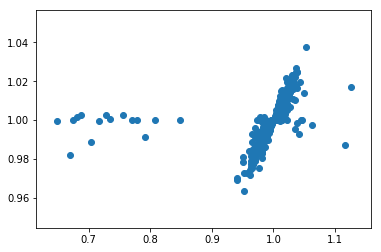

In [86]:
plt.scatter(hits6['logFC'], hits6['True_fitness'])